<h1 style="font-size:30px;">Implementing a CNN in PyTorch</h1>

In this notebook, we’ll learn how to implement a Convolutional Neural Network (CNN) from scratch using PyTorch. Here, we show a custom CNN architecture with fewer layers. We will learn how to model this architecture and train it on a small dataset called [10 Monkey Species](https://www.kaggle.com/slothkong/10-monkey-species).


<center><img src='https://www.dropbox.com/scl/fi/e4541jejdlxzny3vrgw24/Monkey_architecture-updated.png?rlkey=4c3jm0kgzwm4txn1mbewqbox9&st=vq1lb2nt&dl=1' ></center>

## Table of Content

* [1. Download and Extract the Dataset](#1.-Download-and-Extract-the-Dataset)
* [2. Dataset and Training Configuration Parameters](#2.-Dataset-and-Training-Configuration-Parameters)
* [3. Dataset Preprocessing](#3.-Dataset-Preprocessing)
* [4. CNN Model Implementation in PyTorch](#4-CNN-Model-Implementation-in-PyTorch)
* [5. Model Training and Evaluation](#5.-Model-Training-and-Evaluation)
* [6. Saving and Loading Best Model Weights](#6.-Saving-and-Loading-Best-Model-Weights)
* [7. Inference](#7.-Inference)
* [8. Conclusion](#8.-Conclusion)

## Import Dependencies

In [11]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from torchinfo import summary
from torch.utils.tensorboard import SummaryWriter

import torchvision
from torchvision import datasets
from torchvision.transforms import v2 as transforms
from torchvision.ops import Conv2dNormActivation

from dataclasses import dataclass
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import time
import os
import warnings
import random

from tqdm import tqdm

%matplotlib inline
warnings.filterwarnings("ignore")

In [12]:
# Set seed for reproducibilty
def set_seeds(seed):
    random.seed()
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

set_seeds(42)

## 1. Download and Extract the Dataset

<center><img src='https://www.dropbox.com/scl/fi/m5kngoab3d9p6ajbffwr9/Monkey-Species-Dataset.jpg?rlkey=t62unc200y259ltk5kqlxa9cj&st=334vllym&dl=1' width=500 height=500></center>



In [13]:
import requests

url = "https://www.dropbox.com/s/45jdd8padeyjq6t/10_Monkey_Species.zip?dl=1"
output_path = "10_Monkey_Species.zip"

response = requests.get(url, stream=True)
response.raise_for_status()

with open(output_path, "wb") as f:
    for chunk in response.iter_content(chunk_size=8192):
        if chunk:
            f.write(chunk)

print("Download completed!")

Download completed!


In [14]:
!unzip -q "10_Monkey_Species.zip"

## 2. Dataset and Training Configuration Parameters

Before we describe the model implementation and training, we’re going to apply a little more structure to our training process by using the `dataclasses` module in python to create simple `DatasetConfig` and `TrainingConfig` classes to organize several data and training configuration parameters. This allows us to create data structures for configuration parameters, as shown below. The benefit of doing this is that we have a single place to go to make any desired changes.

In [15]:
@dataclass(frozen=True)
class TrainingConfig:
    """Training Configurations"""
    batch_size: int = 32
    num_epochs: int = 100
    learning_rate: float = 1e-4
    log_interval: int = 1
    test_interval: int = 1
    data_root: int = "./"
    num_workers: int = 5
    device: str = "cuda"

train_config = TrainingConfig()
DEVICE = torch.device("cuda") if torch.cuda.is_available() else "cpu"
print(f"Available Device --->> {DEVICE}")

Available Device --->> cuda


<h3 style="font-size:30px;">2.1. Load Custom Datasets in PyTorch</h3>

Till now, we have experimented with datasets like Fashion MNIST available with the PyTorch Torchvision library.

In this notebook, we will see how to load raw images present in a folder.

In the real world, we have need the manage the structure and preprocessing of the dataset on our own.

To illustrate a few preprocessing, we have chosen the [10 Monkey Species](https://www.kaggle.com/slothkong/10-monkey-species) dataset from Kaggle. You can download the data from [here](https://www.kaggle.com/slothkong/10-monkey-species/download). You need to extract data. We have already uploaded the extracted data in the lab.

Each folder contains 10 subforders labeled as n0~n9, each corresponding a species form Wikipedia's monkey cladogram. Images are 400x300 px or larger and JPEG format (almost 1400 images). Images were downloaded with help of the googliser open source code.

**Label mapping:**

| Label | Monkey Species |
| --- | --- |
| n0 | alouatta_palliata |
| n1 | erythrocebus_patas |
| n2 | cacajao_calvus |
| n3 | macaca_fuscata |  
| n4 | cebuella_pygmea |
| n5 | cebus_capucinus |
| n6 | mico_argentatus |
| n7 | saimiri_sciureus |
| n8 | aotus_nigriceps |
| n9 | trachypithecus_johnii |


**Extracted Folder structure:**

```
data_root
├── training
│   └── training
│       ├── n0
│       ├── n1
│       ├── n2
│       ├── n3
│       ├── n4
│       ├── n5
│       ├── n6
│       ├── n7
│       ├── n8
│       └── n9
└── validation
    └── validation
        ├── n0
        ├── n1
        ├── n2
        ├── n3
        ├── n4
        ├── n5
        ├── n6
        ├── n7
        ├── n8
        └── n9

```

`data_root/training/training` has `n0-n9` folders; each folder has images of the corresponding class. Similarly, `data_root/validation/validation` has `n0-n9` folders.

In [16]:
train_root = os.path.join("10_Monkey_Species", "training", "training")
val_root = os.path.join("10_Monkey_Species", "validation", "validation")

In [17]:
df = pd.read_csv(os.path.join("10_Monkey_Species", "monkey_labels.txt"), sep=",", header=None)
df.columns = ["Label", "Latin Name", "Common Name", "Train Images", "Validation Images"]
df['Latin Name'] = df['Latin Name'].str.replace("\t", " ")
df[1:]

,Label,Latin Name,Common Name,Train Images,Validation Images
1,n0,alouatta_palliata,mantled_howler,131,26
2,n1,erythrocebus_patas,patas_monkey,139,28
3,n2,cacajao_calvus,bald_uakari,137,27
4,n3,macaca_fuscata,japanese_macaque,152,30
5,n4,cebuella_pygmea,pygmy_marmoset,131,26
6,n5,cebus_capucinus,white_headed_capuchin,141,28
7,n6,mico_argentatus,silvery_marmoset,132,26
8,n7,saimiri_sciureus,common_squirrel_monkey,142,28
9,n8,aotus_nigriceps,black_headed_night_monkey,133,27
10,n9,trachypithecus_johnii,nilgiri_langur,132,26


## 3. Dataset Preprocessing

Here, we normalize the image data to the range `[0,1]` with `mean` and `std` of our Dataset. This is very common when working with image data which helps the model train more efficiently.

In [18]:
# mean and std of this Monkey Species dataset
mean = [0.4368, 0.4336, 0.3294]
std = [0.2457, 0.2413, 0.2447]

img_size = (224, 224)

preprocess = transforms.Compose(
    [   
        transforms.Resize(img_size, antialias=True),
        transforms.ToTensor()
    ]
)

In [19]:
common_transforms = transforms.Compose([
    preprocess,
    transforms.Normalize(mean, std)
])

train_transforms = transforms.Compose([
    preprocess,
    transforms.RandomHorizontalFlip(),
    # Randomly select a rectangle region in the input image or video and erase its pixels.
    transforms.RandomErasing(p=0.4),
    transforms.RandomApply([
        transforms.RandomAffine(
            degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 0.75)),
    ], p=0.1),
    transforms.Normalize(mean, std)
])


### 3.1. DataLoader Preparation



**PyTorch has inbuilt functionality (`torchvision.datasets.ImageFolder` class) to load such structured image folders:**

```
torchvision.datasets.ImageFolder(root, transform=None, target_transform=None, loader=<function default_loader>, is_valid_file=None)
```

This is a generic data loader where the images are arranged in this way:

```
root/n0/xxx.png
root/n0/xxy.jpg
root/n0/xxz.png

root/n1/123.jpg
root/n1/nsdf3.png
root/n1/asd932_.png

    :
    :
    
root/n9/1b23.jpg
root/n9/nsasdf3.png
root/n9/as2wdd932_.png
    
```

Parameters:

- `root` (string) - Root directory path.

- `transform` (callable, optional) - A function/transform that takes in an PIL image and returns a transformed version. E.g, `transforms.RandomCrop`.

- `target_transform` (callable, optional) - A function/transform that takes in the target and transforms it.

- `loader` (callable, optional) - A function to load an image given its path.

- `is_valid_file` - A function that takes path of an Image file and check if the file is a valid file (used to check of corrupt files).

Find more details [here](https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision.datasets.ImageFolder).


In [20]:
# Apply augmentations to the training dataset
train_data = datasets.ImageFolder(root=train_root, transform=train_transforms)

# The validation dataset should have only common transforms like Resize, ToTensor and Normalize.
val_data = datasets.ImageFolder(root=val_root, transform=common_transforms)

train_data.classes, val_data.class_to_idx

(['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9'],
 {'n0': 0,
  'n1': 1,
  'n2': 2,
  'n3': 3,
  'n4': 4,
  'n5': 5,
  'n6': 6,
  'n7': 7,
  'n8': 8,
  'n9': 9})

In [21]:
len(train_data), len(val_data)

(1097, 272)

**Uncomment the following code block if you would like to find the mean and std of the dataset.**

In [22]:
def get_mean_std(train_loader, img_size=(224, 224), num_workers=2):

    batch_mean = torch.zeros(3)
    batch_mean_sqrd = torch.zeros(3)

    for batch_data, _ in train_loader:
        batch_mean += batch_data.mean(dim=(0, 2, 3))  # E[batch_i]
        batch_mean_sqrd += (batch_data**2).mean(dim=(0, 2, 3))  #  E[batch_i**2]

    mean = batch_mean / len(train_loader)

    var = (batch_mean_sqrd / len(train_loader)) - (mean**2)

    std = var**0.5
    print("mean: {}, std: {}".format(mean, std))

    return mean, std

train_data_mean_calc = datasets.ImageFolder(root=train_root, transform = preprocess)
train_loader_mean_calc = DataLoader(train_data_mean_calc, shuffle=True,
                                    batch_size=TrainingConfig.batch_size, num_workers=TrainingConfig.num_workers)
mean, std = get_mean_std(train_loader_mean_calc)

print("Mean of Dataset: ", mean)
print("Std of Dataset: ", std)

mean: tensor([0.4363, 0.4333, 0.3292]), std: tensor([0.2465, 0.2422, 0.2454])
Mean of Dataset:  tensor([0.4363, 0.4333, 0.3292])
Std of Dataset:  tensor([0.2465, 0.2422, 0.2454])


- **Data Loaders**

In [23]:
train_loader = DataLoader(
    train_data,
    shuffle=True,
    batch_size=TrainingConfig.batch_size,
    num_workers= TrainingConfig.num_workers
)

val_loader = DataLoader(
    val_data,
    shuffle=False,
    batch_size=TrainingConfig.batch_size,
    num_workers=TrainingConfig.num_workers
)

In [24]:
len(next(iter(train_loader)))

2

In [25]:
class_mapping = {

    0: "mantled_howler",
    1: "patas_monkey",
    2: "bald_uakari",
    3: "japanese_macaque",
    4: "pygmy_marmoset",
    5: "white_headed_capuchin",
    6: "silvery_marmoset",
    7: "common_squirrel_monkey",
    8: "black_headed_night_monkey",
    9: "nilgiri_langur"
}

### 3.2. Display Sample Images from the Dataset


torch.Size([32, 3, 224, 224])
torch.Size([32])


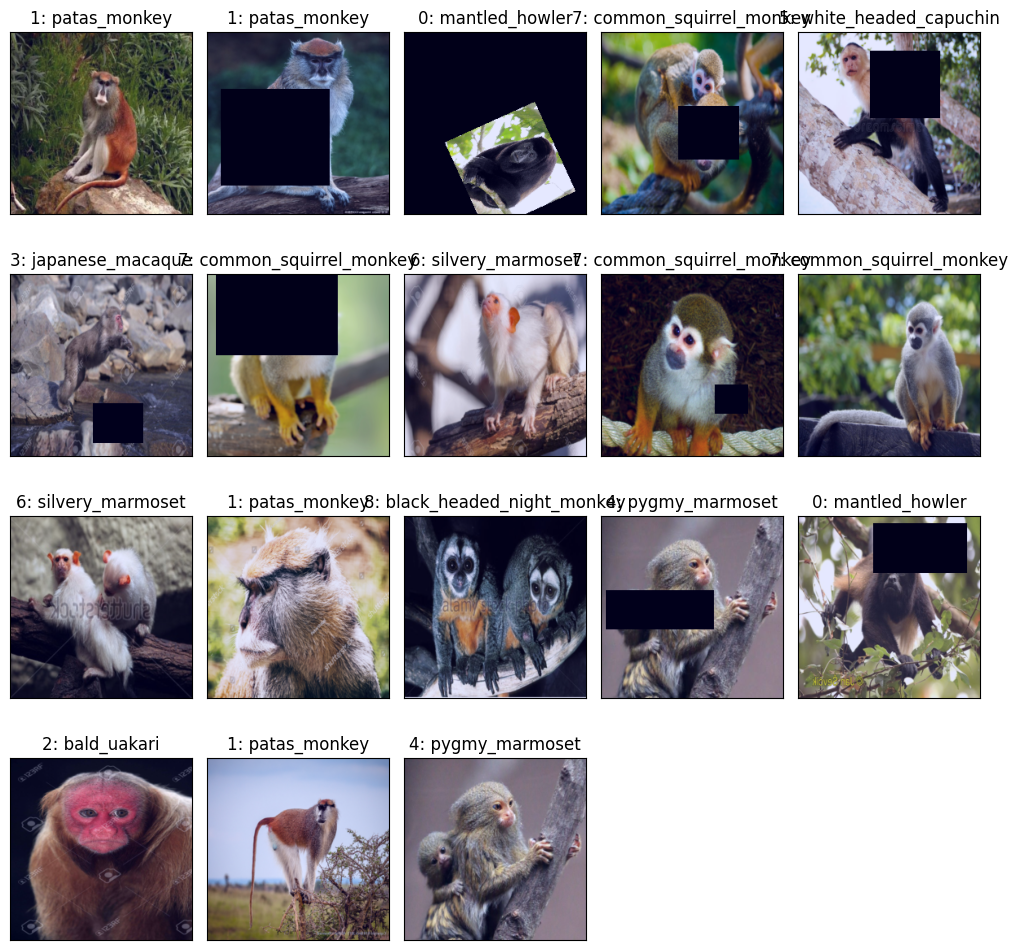

In [26]:
def visualize_images(data_loader, num_images=20):
    fig = plt.figure(figsize=(10, 10))

    # Iterate over First Batch
    images, labels = next(iter(data_loader))
    print(images.shape)
    print(labels.shape)

    num_rows = 4
    num_cols = int(np.ceil((num_images / num_rows)))

    for idx in range(min(num_images, len(images))):
        image, label = images[idx], labels[idx]
        ax = fig.add_subplot(num_rows, num_cols, idx+1, xticks=[], yticks=[])
        image = image.permute(1, 2, 0)  # (H, W, C)

        # Normalize images to be in range [0, 1]
        image = (image - image.min()) / (image.max() - image.min())
        ax.imshow(image, cmap='gray')
        ax.set_title(f"{label.item()}: {class_mapping[label.item()]}")

    fig.tight_layout()
    plt.show()


visualize_images(train_loader, num_images=18)

## 4. CNN Model Implementation in PyTorch

### 4.1. Define the Convolutional Blocks
- To define a convolutional layer in PyTorch, we call the `nn.Conv2D()` function, which accepts several input arguments.
- First, we define the layer to have `32` filters. 
- The kernel size for first filter is `5` and the subsequent layers filter is `3` (which is interpreted as `3x3`).
- We can use a padding option called `same`, which will pad the input tensor so that the output of the convolution operation has the same spatial size as the input. This is not required, but it’s commonly used. if you don’t explicitly specify this padding option, then the default behavior has no padding, and therefore, the spatial size of output from the convolutional layer will be slightly smaller than the input size.
- After each convolutional layer, we add a `BatchNorm2d` layer, which normalizes the activations of the previous layer at each batch, thereby improving the `training speed and stability of the network`. 
- We use a `ReLU`  activation function in all the layers in the Network except for the output layer. 
- This sequence of `Conv2d` followed by `BatchNorm2d` and `ReLU` is called `Conv2dNormActivation` and torchvision has a convenience function to implement this by [`torchvision.ops.Conv2dNormActivation()`](https://pytorch.org/vision/main/generated/torchvision.ops.Conv2dNormActivation.html#conv2dnormactivation).


- There is also another alternative approach to specify `Conv2d` layers with [`nn.LazyConv2d()`](https://pytorch.org/docs/stable/generated/torch.nn.LazyConv2d.html#lazyconv2d) where the `input_channels` is automatically inferred from the previous `Conv2d` layers `output_channels`.

- The first two convolutional layers has `32` filters each, and then we follow that with a max pooling layer that has a window size of `(2x2)`,  so the output shape from this first convolution block is `(218 x 218 x 32)`. Next, we have the second convolutional block, has `64` and `128` filters in each convolutional layer instead of `32`, and then finally, the third and fourth convolutional block has `256` and `512` filters.

- **Note**: The number of filters in each convolutional layer is something that you will need to experiment with. A `larger number of filters allows the model to have a greater learning capacity`, but this also `needs to be balanced with the amount of data available to train the model`. Adding too many filters (or layers) can lead to overfitting, one of the most common issues encountered when training models.



<img src='https://www.dropbox.com/scl/fi/u3o12g52hbqkgexd2h89l/CNN-Architecure-PyTorch.png?rlkey=yqk1pwobiy82aan4qslv0kb5y&st=az71d8ti&dl=1'  align='center'>


- The final layer in the feature extractor is the [`nn.AdaptiveAvgPool2d()`](https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html#adaptiveavgpool2d), which applies a `2D adaptive average pooling` over an input image composed of several input channels. This layer ensures that the output has a fixed size of H x W, regardless of the input size. The number of output features is equal to the number of input channels. This is particularly useful for making the subsequent fully connected layers agnostic to the input size.

- Before we define the fully connected layers for the classifier, we need to first flatten the two-dimensional activation maps that are produced by the last convolutional layer (which have a spatial shape of `3x3` with `512` channels). This is accomplished by calling the `nn.Flatten()` function to create a 1-dimensional vector of length `4608`. We then add a densely connected layer with `256` neurons and a fully connected output layer with `10` neurons because we have ten classes in our dataset.

We will show the different ways in which a `Conv2d` -> `BatchNorm` -> `ReLU`

In [27]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            # ---------------------- Convolution Layers ----------------------
            # ---------------------------------------------------
            # Conv2d Norm Activation Block1: 32 Filters, MaxPool.
            # ---------------------------------------------------
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),

            # -------------------------------------------------------------------------
            # Conv2d Norm Activation Block2: 64, 128 Filters, MaxPool, Dropout(p=0.25).
            # -------------------------------------------------------------------------
            # The in_channels argument of the Conv2d that is inferred from the input.size(1).
            nn.LazyConv2d(out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.LazyConv2d(out_channels=128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),

            # --------------------------------------------------------------
            # Conv2d Norm Activation Block3: 128, 256, 512 Filters, MaxPool.
            # --------------------------------------------------------------
            Conv2dNormActivation(in_channels=128, out_channels=256, kernel_size=3),
            Conv2dNormActivation(in_channels=256, out_channels=256, kernel_size=3),
            nn.MaxPool2d(kernel_size=2),
            Conv2dNormActivation(in_channels=256, out_channels=512, kernel_size=3),
            nn.MaxPool2d(kernel_size=2),

            # ---------------------- Feed Forward Layers --------------------
            nn.AdaptiveAvgPool2d(output_size=(3, 3)),

            # Flatten the convolutional features.
            nn.Flatten(),

            # Classification Head.
            nn.Linear(in_features=512*3*3, out_features=256),
            nn.Linear(in_features=256, out_features=10)
        )

    def forward(self, x):
        return self.model(x)

In [28]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else "cpu"
cnn_model = CNN()
optimizer = Adam(cnn_model.parameters(), lr=TrainingConfig.learning_rate)

logdir = "runs/80epochs-3.3M_param_dropout"

writer = SummaryWriter(logdir)

dummy_input = (1, 3, 224, 224)
print(summary(cnn_model, dummy_input,
    row_settings=["var_names"], device="cpu"))

Layer (type (var_name))                  Output Shape              Param #
CNN (CNN)                                [1, 10]                   --
├─Sequential (model)                     [1, 10]                   --
│    └─Conv2d (0)                        [1, 32, 220, 220]         2,432
│    └─BatchNorm2d (1)                   [1, 32, 220, 220]         64
│    └─ReLU (2)                          [1, 32, 220, 220]         --
│    └─Conv2d (3)                        [1, 32, 218, 218]         9,248
│    └─BatchNorm2d (4)                   [1, 32, 218, 218]         64
│    └─ReLU (5)                          [1, 32, 218, 218]         --
│    └─MaxPool2d (6)                     [1, 32, 109, 109]         --
│    └─Conv2d (7)                        [1, 64, 107, 107]         18,496
│    └─BatchNorm2d (8)                   [1, 64, 107, 107]         128
│    └─ReLU (9)                          [1, 64, 107, 107]         --
│    └─Conv2d (10)                       [1, 128, 105, 105]        73,856


## 5. Model Training and Evaluation

In [29]:
def train(model, train_loader):
    model.train()
    model.to(DEVICE)

    # To Calc. Average Loss
    running_loss = 0.0
    # To Calc. The Accuracy
    correct_predictions = 0
    total_train_samples = 0
    
    for images, labels in tqdm(train_loader, desc="Training"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, dim=1)
        total_train_samples += labels.shape[0]
        correct_predictions += (predicted == labels).sum().item()

    train_avg_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_predictions / total_train_samples
    return train_avg_loss, train_accuracy


def validation(model, train_loader):
    model.eval()
    model.to(DEVICE)

    # To Calc. Average Loss
    running_loss = 0.0
    # To Calc. The Accuracy
    correct_predictions = 0
    total_train_samples = 0

    for images, labels in tqdm(train_loader, desc="Validation"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        with torch.no_grad():
            outputs = model(images)

        loss = F.cross_entropy(outputs, labels)
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, dim=1)
        total_train_samples += labels.shape[0]
        correct_predictions += (predicted == labels).sum().item()

    val_avg_loss = running_loss / len(train_loader)
    val_accuracy = 100 * correct_predictions / total_train_samples
    return val_avg_loss, val_accuracy

In [ ]:
def main(model, train_loader, val_loader):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    best_val_acc = 0.0
    best_weights = None

    for epoch in range(TrainingConfig.num_epochs):
        train_loss, train_accuracy = train(model, train_loader)
        val_loss, val_accuracy = validation(model, val_loader)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1:0>2}/{train_config.num_epochs} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}% - Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

        # Logging metrics to tensorboard
        writer.add_scalar('Loss/train', train_loss)
        writer.add_scalar('Loss/val', val_loss)
        writer.add_scalar('Accuracy/train', train_accuracy)
        writer.add_scalar('Accuracy/val', val_accuracy)

        if val_accuracy > best_val_acc:
            # Save the Best Model Accuracy and its weights
            best_val_acc = val_accuracy
            best_weights = model.state_dict()
            print(f"Saving best model...💾")
            torch.save(best_weights, "best.pt")

    return train_losses, train_accuracies, val_losses, val_accuracies

In [31]:
train_losses, train_accuracies, val_losses, val_accuracies = main(cnn_model, train_loader, val_loader)

Validation: 100%|██████████| 9/9 [00:06<00:00,  1.49it/s]


Epoch 01/100 - Train Loss: 1.9614, Train Accuracy: 31.72% - Val Loss: 1.9297, Val Accuracy: 29.78%
Saving best model...💾


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.44it/s]


Epoch 02/100 - Train Loss: 1.4566, Train Accuracy: 49.86% - Val Loss: 1.3732, Val Accuracy: 50.74%
Saving best model...💾


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.46it/s]


Epoch 03/100 - Train Loss: 1.2557, Train Accuracy: 55.97% - Val Loss: 1.4565, Val Accuracy: 52.57%
Saving best model...💾


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.74it/s]


Epoch 04/100 - Train Loss: 1.1645, Train Accuracy: 58.80% - Val Loss: 1.1334, Val Accuracy: 60.29%
Saving best model...💾


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.71it/s]


Epoch 05/100 - Train Loss: 1.0868, Train Accuracy: 62.53% - Val Loss: 1.1005, Val Accuracy: 61.76%
Saving best model...💾


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.47it/s]


Epoch 06/100 - Train Loss: 1.0085, Train Accuracy: 65.54% - Val Loss: 0.9554, Val Accuracy: 65.81%
Saving best model...💾


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.39it/s]


Epoch 07/100 - Train Loss: 0.9150, Train Accuracy: 70.37% - Val Loss: 0.9704, Val Accuracy: 66.54%
Saving best model...💾


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.55it/s]


Epoch 08/100 - Train Loss: 0.8947, Train Accuracy: 69.64% - Val Loss: 0.9445, Val Accuracy: 69.49%
Saving best model...💾


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.66it/s]


Epoch 09/100 - Train Loss: 0.7688, Train Accuracy: 75.02% - Val Loss: 0.8694, Val Accuracy: 69.49%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.53it/s]


Epoch 10/100 - Train Loss: 0.8205, Train Accuracy: 71.92% - Val Loss: 0.9431, Val Accuracy: 70.96%
Saving best model...💾


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.43it/s]


Epoch 11/100 - Train Loss: 0.7775, Train Accuracy: 72.65% - Val Loss: 0.8826, Val Accuracy: 71.32%
Saving best model...💾


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.58it/s]


Epoch 12/100 - Train Loss: 0.7271, Train Accuracy: 73.20% - Val Loss: 0.8337, Val Accuracy: 70.22%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.68it/s]


Epoch 13/100 - Train Loss: 0.7011, Train Accuracy: 76.94% - Val Loss: 0.9079, Val Accuracy: 72.06%
Saving best model...💾


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.49it/s]


Epoch 14/100 - Train Loss: 0.6534, Train Accuracy: 79.22% - Val Loss: 0.7517, Val Accuracy: 76.47%
Saving best model...💾


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.40it/s]


Epoch 15/100 - Train Loss: 0.6166, Train Accuracy: 78.40% - Val Loss: 0.7969, Val Accuracy: 77.21%
Saving best model...💾


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.68it/s]


Epoch 16/100 - Train Loss: 0.5862, Train Accuracy: 80.40% - Val Loss: 0.8024, Val Accuracy: 74.63%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.67it/s]


Epoch 17/100 - Train Loss: 0.5996, Train Accuracy: 79.12% - Val Loss: 0.8213, Val Accuracy: 77.94%
Saving best model...💾


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]


Epoch 18/100 - Train Loss: 0.4915, Train Accuracy: 83.14% - Val Loss: 0.8868, Val Accuracy: 72.43%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.49it/s]


Epoch 19/100 - Train Loss: 0.5719, Train Accuracy: 81.40% - Val Loss: 0.6721, Val Accuracy: 76.10%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.68it/s]


Epoch 20/100 - Train Loss: 0.5166, Train Accuracy: 82.59% - Val Loss: 0.7106, Val Accuracy: 76.47%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.70it/s]


Epoch 21/100 - Train Loss: 0.5307, Train Accuracy: 83.04% - Val Loss: 0.8188, Val Accuracy: 75.74%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]


Epoch 22/100 - Train Loss: 0.5286, Train Accuracy: 82.86% - Val Loss: 1.0234, Val Accuracy: 68.75%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]


Epoch 23/100 - Train Loss: 0.4611, Train Accuracy: 85.96% - Val Loss: 0.7222, Val Accuracy: 76.84%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.62it/s]


Epoch 24/100 - Train Loss: 0.4579, Train Accuracy: 84.96% - Val Loss: 0.6803, Val Accuracy: 79.04%
Saving best model...💾


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.66it/s]


Epoch 25/100 - Train Loss: 0.4000, Train Accuracy: 87.24% - Val Loss: 0.9241, Val Accuracy: 75.00%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]


Epoch 26/100 - Train Loss: 0.4289, Train Accuracy: 86.14% - Val Loss: 0.7496, Val Accuracy: 75.37%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]


Epoch 27/100 - Train Loss: 0.4310, Train Accuracy: 86.69% - Val Loss: 0.7977, Val Accuracy: 76.84%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.69it/s]


Epoch 28/100 - Train Loss: 0.4050, Train Accuracy: 87.15% - Val Loss: 0.7013, Val Accuracy: 79.41%
Saving best model...💾


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.70it/s]


Epoch 29/100 - Train Loss: 0.3976, Train Accuracy: 85.96% - Val Loss: 0.7921, Val Accuracy: 75.00%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]


Epoch 30/100 - Train Loss: 0.3892, Train Accuracy: 86.69% - Val Loss: 0.8300, Val Accuracy: 72.79%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.54it/s]


Epoch 31/100 - Train Loss: 0.4144, Train Accuracy: 86.14% - Val Loss: 0.6271, Val Accuracy: 80.88%
Saving best model...💾


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.69it/s]


Epoch 32/100 - Train Loss: 0.3475, Train Accuracy: 88.61% - Val Loss: 0.6886, Val Accuracy: 83.46%
Saving best model...💾


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.69it/s]


Epoch 33/100 - Train Loss: 0.4155, Train Accuracy: 85.41% - Val Loss: 0.8668, Val Accuracy: 77.94%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.43it/s]


Epoch 34/100 - Train Loss: 0.3773, Train Accuracy: 87.78% - Val Loss: 0.8179, Val Accuracy: 77.21%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.44it/s]


Epoch 35/100 - Train Loss: 0.3242, Train Accuracy: 89.79% - Val Loss: 0.6765, Val Accuracy: 80.51%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.70it/s]


Epoch 36/100 - Train Loss: 0.2858, Train Accuracy: 90.43% - Val Loss: 0.7985, Val Accuracy: 77.57%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.70it/s]


Epoch 37/100 - Train Loss: 0.3154, Train Accuracy: 89.79% - Val Loss: 0.6726, Val Accuracy: 81.99%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.63it/s]


Epoch 38/100 - Train Loss: 0.2682, Train Accuracy: 91.52% - Val Loss: 0.6986, Val Accuracy: 78.68%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.39it/s]


Epoch 39/100 - Train Loss: 0.2908, Train Accuracy: 90.79% - Val Loss: 0.7713, Val Accuracy: 81.62%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.50it/s]


Epoch 40/100 - Train Loss: 0.3015, Train Accuracy: 90.15% - Val Loss: 0.6281, Val Accuracy: 82.35%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.68it/s]


Epoch 41/100 - Train Loss: 0.2982, Train Accuracy: 90.70% - Val Loss: 0.8480, Val Accuracy: 75.37%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.65it/s]


Epoch 42/100 - Train Loss: 0.2686, Train Accuracy: 91.61% - Val Loss: 0.8584, Val Accuracy: 77.94%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]


Epoch 43/100 - Train Loss: 0.2894, Train Accuracy: 89.70% - Val Loss: 0.7301, Val Accuracy: 79.78%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.53it/s]


Epoch 44/100 - Train Loss: 0.2837, Train Accuracy: 90.88% - Val Loss: 0.6213, Val Accuracy: 82.72%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.64it/s]


Epoch 45/100 - Train Loss: 0.2671, Train Accuracy: 91.34% - Val Loss: 0.8612, Val Accuracy: 79.04%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.52it/s]


Epoch 46/100 - Train Loss: 0.2785, Train Accuracy: 91.61% - Val Loss: 0.8887, Val Accuracy: 75.74%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.39it/s]


Epoch 47/100 - Train Loss: 0.2452, Train Accuracy: 92.16% - Val Loss: 0.6306, Val Accuracy: 81.99%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.68it/s]


Epoch 48/100 - Train Loss: 0.2693, Train Accuracy: 90.88% - Val Loss: 0.6986, Val Accuracy: 80.51%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.69it/s]


Epoch 49/100 - Train Loss: 0.2836, Train Accuracy: 91.70% - Val Loss: 0.6913, Val Accuracy: 80.51%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.44it/s]


Epoch 50/100 - Train Loss: 0.2461, Train Accuracy: 91.80% - Val Loss: 0.6821, Val Accuracy: 81.25%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.43it/s]


Epoch 51/100 - Train Loss: 0.2334, Train Accuracy: 92.62% - Val Loss: 0.6781, Val Accuracy: 82.72%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.71it/s]


Epoch 52/100 - Train Loss: 0.2492, Train Accuracy: 93.16% - Val Loss: 0.7685, Val Accuracy: 81.25%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.64it/s]


Epoch 53/100 - Train Loss: 0.2666, Train Accuracy: 90.79% - Val Loss: 0.9131, Val Accuracy: 75.00%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.47it/s]


Epoch 54/100 - Train Loss: 0.2460, Train Accuracy: 91.34% - Val Loss: 0.7892, Val Accuracy: 79.41%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.39it/s]


Epoch 55/100 - Train Loss: 0.2104, Train Accuracy: 92.89% - Val Loss: 0.7718, Val Accuracy: 77.21%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.59it/s]


Epoch 56/100 - Train Loss: 0.1906, Train Accuracy: 94.35% - Val Loss: 0.7847, Val Accuracy: 80.88%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.73it/s]


Epoch 57/100 - Train Loss: 0.2508, Train Accuracy: 90.98% - Val Loss: 0.7924, Val Accuracy: 80.88%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.72it/s]


Epoch 58/100 - Train Loss: 0.2528, Train Accuracy: 92.53% - Val Loss: 0.9300, Val Accuracy: 77.94%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.59it/s]


Epoch 59/100 - Train Loss: 0.2144, Train Accuracy: 93.35% - Val Loss: 0.8271, Val Accuracy: 80.88%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.39it/s]


Epoch 60/100 - Train Loss: 0.2348, Train Accuracy: 92.62% - Val Loss: 0.8313, Val Accuracy: 81.62%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.58it/s]


Epoch 61/100 - Train Loss: 0.2140, Train Accuracy: 93.25% - Val Loss: 0.8517, Val Accuracy: 80.51%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.67it/s]


Epoch 62/100 - Train Loss: 0.2360, Train Accuracy: 92.71% - Val Loss: 0.6438, Val Accuracy: 82.72%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.58it/s]


Epoch 63/100 - Train Loss: 0.2507, Train Accuracy: 91.34% - Val Loss: 1.0339, Val Accuracy: 72.43%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.40it/s]


Epoch 64/100 - Train Loss: 0.2591, Train Accuracy: 91.34% - Val Loss: 0.7799, Val Accuracy: 80.51%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.52it/s]


Epoch 65/100 - Train Loss: 0.1856, Train Accuracy: 94.17% - Val Loss: 0.7345, Val Accuracy: 81.25%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.68it/s]


Epoch 66/100 - Train Loss: 0.1601, Train Accuracy: 94.99% - Val Loss: 0.7015, Val Accuracy: 82.72%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.62it/s]


Epoch 67/100 - Train Loss: 0.2034, Train Accuracy: 93.53% - Val Loss: 0.8162, Val Accuracy: 81.62%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]


Epoch 68/100 - Train Loss: 0.2329, Train Accuracy: 92.07% - Val Loss: 0.7622, Val Accuracy: 83.09%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]


Epoch 69/100 - Train Loss: 0.2324, Train Accuracy: 92.53% - Val Loss: 0.9347, Val Accuracy: 76.10%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.69it/s]


Epoch 70/100 - Train Loss: 0.2377, Train Accuracy: 91.25% - Val Loss: 0.9167, Val Accuracy: 79.41%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.71it/s]


Epoch 71/100 - Train Loss: 0.1913, Train Accuracy: 93.07% - Val Loss: 0.7885, Val Accuracy: 81.62%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.54it/s]


Epoch 72/100 - Train Loss: 0.1702, Train Accuracy: 94.62% - Val Loss: 0.7226, Val Accuracy: 80.88%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]


Epoch 73/100 - Train Loss: 0.1729, Train Accuracy: 94.71% - Val Loss: 0.7549, Val Accuracy: 79.41%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.60it/s]


Epoch 74/100 - Train Loss: 0.1843, Train Accuracy: 93.80% - Val Loss: 0.6975, Val Accuracy: 84.56%
Saving best model...💾


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.67it/s]


Epoch 75/100 - Train Loss: 0.1859, Train Accuracy: 94.17% - Val Loss: 0.7885, Val Accuracy: 83.82%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.60it/s]


Epoch 76/100 - Train Loss: 0.1981, Train Accuracy: 93.25% - Val Loss: 0.8580, Val Accuracy: 78.68%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.43it/s]


Epoch 77/100 - Train Loss: 0.1931, Train Accuracy: 93.35% - Val Loss: 1.0263, Val Accuracy: 75.00%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.47it/s]


Epoch 78/100 - Train Loss: 0.2067, Train Accuracy: 93.16% - Val Loss: 0.8307, Val Accuracy: 79.78%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.69it/s]


Epoch 79/100 - Train Loss: 0.1966, Train Accuracy: 94.26% - Val Loss: 0.7824, Val Accuracy: 82.35%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.70it/s]


Epoch 80/100 - Train Loss: 0.1928, Train Accuracy: 93.07% - Val Loss: 0.9346, Val Accuracy: 78.31%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.37it/s]


Epoch 81/100 - Train Loss: 0.1894, Train Accuracy: 93.44% - Val Loss: 0.8806, Val Accuracy: 79.41%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.37it/s]


Epoch 82/100 - Train Loss: 0.1514, Train Accuracy: 94.99% - Val Loss: 0.8308, Val Accuracy: 80.88%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.67it/s]


Epoch 83/100 - Train Loss: 0.1668, Train Accuracy: 94.53% - Val Loss: 1.1389, Val Accuracy: 76.84%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.69it/s]


Epoch 84/100 - Train Loss: 0.2193, Train Accuracy: 91.70% - Val Loss: 0.7205, Val Accuracy: 84.56%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.59it/s]


Epoch 85/100 - Train Loss: 0.2068, Train Accuracy: 93.71% - Val Loss: 0.8107, Val Accuracy: 79.78%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.45it/s]


Epoch 86/100 - Train Loss: 0.2168, Train Accuracy: 93.25% - Val Loss: 0.8996, Val Accuracy: 81.25%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.49it/s]


Epoch 87/100 - Train Loss: 0.2491, Train Accuracy: 91.07% - Val Loss: 1.0386, Val Accuracy: 77.94%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.72it/s]


Epoch 88/100 - Train Loss: 0.1771, Train Accuracy: 95.26% - Val Loss: 0.8216, Val Accuracy: 80.51%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.74it/s]


Epoch 89/100 - Train Loss: 0.1583, Train Accuracy: 94.26% - Val Loss: 0.7663, Val Accuracy: 82.35%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.64it/s]


Epoch 90/100 - Train Loss: 0.2036, Train Accuracy: 92.98% - Val Loss: 0.7278, Val Accuracy: 84.19%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.45it/s]


Epoch 91/100 - Train Loss: 0.1779, Train Accuracy: 94.17% - Val Loss: 0.7045, Val Accuracy: 84.93%
Saving best model...💾


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.44it/s]


Epoch 92/100 - Train Loss: 0.1552, Train Accuracy: 95.17% - Val Loss: 0.7816, Val Accuracy: 79.78%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.65it/s]


Epoch 93/100 - Train Loss: 0.2063, Train Accuracy: 92.98% - Val Loss: 0.7806, Val Accuracy: 80.88%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.66it/s]


Epoch 94/100 - Train Loss: 0.1803, Train Accuracy: 94.26% - Val Loss: 0.8153, Val Accuracy: 79.78%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.48it/s]


Epoch 95/100 - Train Loss: 0.1517, Train Accuracy: 94.99% - Val Loss: 0.7666, Val Accuracy: 82.35%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]


Epoch 96/100 - Train Loss: 0.1708, Train Accuracy: 94.99% - Val Loss: 1.0496, Val Accuracy: 80.15%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.68it/s]


Epoch 97/100 - Train Loss: 0.1784, Train Accuracy: 93.71% - Val Loss: 0.9584, Val Accuracy: 81.62%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.66it/s]


Epoch 98/100 - Train Loss: 0.1520, Train Accuracy: 95.17% - Val Loss: 0.8863, Val Accuracy: 81.99%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]


Epoch 99/100 - Train Loss: 0.1989, Train Accuracy: 94.62% - Val Loss: 0.7679, Val Accuracy: 80.15%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

Epoch 100/100 - Train Loss: 0.2241, Train Accuracy: 92.62% - Val Loss: 0.9318, Val Accuracy: 80.15%


We got best accuracy of **84.93%** val accuracy after training for 100 epochs.

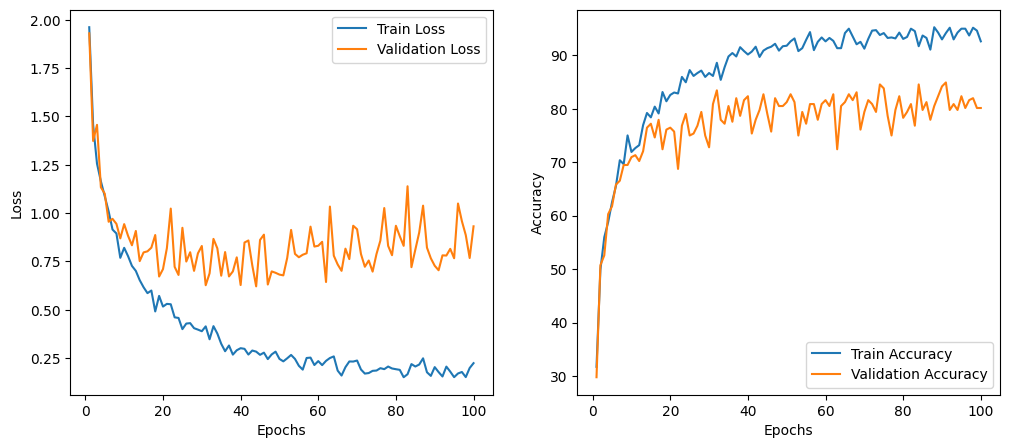

In [32]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, train_config.num_epochs + 1),
         train_losses, label="Train Loss")
plt.plot(range(1, train_config.num_epochs + 1),
         val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, train_config.num_epochs + 1),
         train_accuracies, label="Train Accuracy")
plt.plot(range(1, train_config.num_epochs + 1),
         val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### 6. Saving and Loading Best Model Weights
Saving and loading best model weights are very convenient with `torch.save()`. This enables you to develop and train a model, save it to the file system and then load it with `torch.load()`.

In [38]:
# Load the Best Model Weights
cnn_model.load_state_dict(torch.load("best.pt"))
cnn_model.eval()

CNN(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2dNormActivation(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), 

## 7. Inference

In [39]:
def prediction(model, val_loader):
    model.eval()
    model.to(DEVICE)

    all_images, all_labels = [], []
    all_pred_indices, all_pred_probs = [], []

    for images, labels in val_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        with torch.inference_mode():
            outputs = model(images)
        
        prob = F.softmax(outputs, dim=1)
        pred_indices = prob.data.max(dim=1)[1]
        pred_probs = prob.data.max(dim=1)[0]

        all_images.append(images.cpu())
        all_labels.append(labels.cpu())
        all_pred_indices.append(pred_indices.cpu())
        all_pred_probs.append(pred_probs.cpu())

    return (torch.cat(all_images).numpy(),
            torch.cat(all_labels).numpy(),
            torch.cat(all_pred_indices).numpy(),
            torch.cat(all_pred_probs).numpy())

We will need to denormalize our pixel values values by multiplying std and adding mean value to our image for ***Matplotlib visualization***. `np.clip` makes the pixel values to be in range of `[0,1]`

In [40]:
def denormalize(image):
    mean_ar = np.array(mean)
    std_ar = np.array(std)
    image = image * std_ar + mean_ar
    return np.clip(image, 0, 1)


def visualise_predictions(sample_images, sample_gt_labels, pred_indices, pred_probs, num_images=5):

    fig = plt.figure(figsize=(20, 5))

    for i in range(num_images):
        idx = random.randint(0, len(sample_images) - 1)
        image = sample_images[idx].transpose(1, 2, 0)  # (C,H,W) --> (H,W,C)
        label = sample_gt_labels[idx]
        pred_idx = pred_indices[idx]
        pred_prob = pred_probs[idx]

        image = denormalize(image)

        ax = fig.add_subplot(1, num_images, i+1)
        ax.imshow(image)
        ax.set_title(f"GT: {class_mapping[label]}\nPred: {class_mapping[pred_idx]} ({pred_prob:.2f})")
        ax.axis('off')

    plt.show()

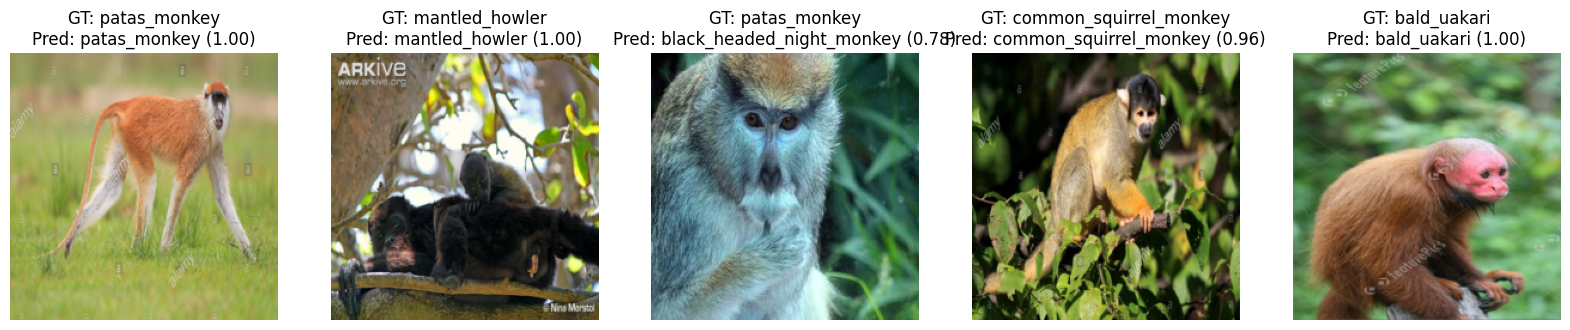

In [41]:
val_images, val_gt_labels, pred_indices, pred_probs = prediction(cnn_model, val_loader)

visualise_predictions(val_images, val_gt_labels, pred_indices, pred_probs, num_images=5)

### **7.1. Confusion  matrix**

A confusion matrix is a very common metric that is used to summarize the results of a classification problem. The information is presented in the form of a table or matrix where one axis represents the ground truth labels for each class, and the other axis represents the predicted lables from the network. The entries in the table represent the number of instances from an experiment (which are sometimes represented as percentages rather than counts). Generating a confusion matrix is accomplished by calling the `confusion_matrix` from `sklearn.metrics`, which takes two required arguments which are the list of ground truth labels and the associated predicted lables.

---
It can be very informative to better understand where the model performs well and where it may have more difficulty.  For example, a few things stand out right away. The model does a very good job in identifying different classes even though there is probable chance of misclassifying, as it is a same species dataset. So all of these observations make intuitive sense, given the similarity of the classes involved.

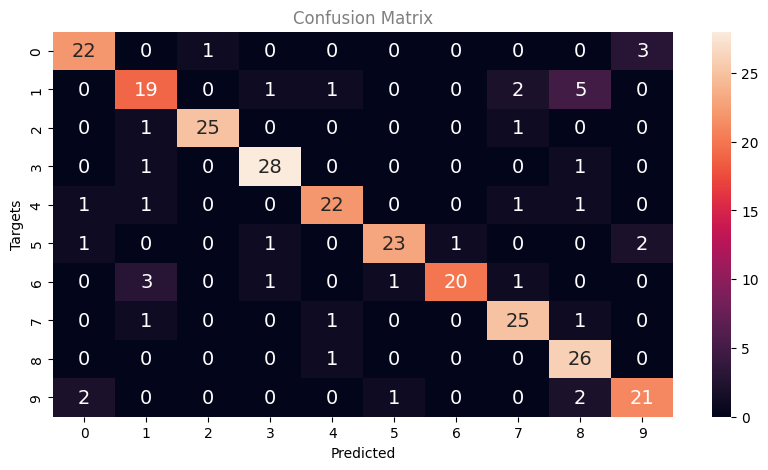

In [42]:
cm = confusion_matrix(val_gt_labels, pred_indices)

plt.figure(figsize=[10, 5])
sns.heatmap(cm, annot=True, fmt='d', annot_kws={"size": 14})
plt.xlabel("Predicted")
plt.ylabel("Targets")
plt.title(f"Confusion Matrix", color="gray")
plt.show()

## 8. Conclusion

In this notebook, we learned how to use PyTorch to define and train a simple convolutional neural network. We learned how to use `BatchNorm2d` layers as a regularization technique to improve the model's performance on the validation dataset. We also covered how to save and load models to and from the file system. Finally, we evaluated the model's training with a confusion matrix.